In [1]:
import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import re

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

In [2]:
# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts.
    
    Args:
        data: 字典格式的数据，包含预测值或标签
        flatten: 是否将数据展平为一维数组
        
    Returns:
        sort_data: 重新格式化后的numpy数组
    """
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    
    # 检查数据类型并相应处理
    if isinstance(sort_data[0], torch.Tensor):
        sort_data = torch.cat(sort_data, dim=0)
        sort_data = sort_data.cpu().numpy()  # 转换为numpy数组
    else:
        sort_data = np.concatenate(sort_data, axis=0)

    if flatten:
        sort_data = np.reshape(sort_data, (-1))
    
    return sort_data

def _process_signal(signal, fs=30, diff_flag=True):
    """处理PPG信号:去趋势和滤波
    
    Args:
        signal: 输入的PPG信号
        fs: 采样频率,默认30Hz
        diff_flag: 信号是否为PPG的一阶导数
        
    Returns:
        signal: 处理后的信号
    """
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """去除PPG信号的趋势项
    
    Args:
        input_signal: 输入的PPG信号
        lambda_value: 正则化参数
        
    Returns:
        detrended_signal: 去趋势后的信号
    """
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal


In [3]:
data_out_path = "/home/robo/zhao_code/rPPG/MyPhysNet/logs/exp3/test_results.pkl"  # Output Data Path 
trial_idx = 0
chunk_size = 128 # size of chunk to visualize: -1 will plot the entire signal
chunk_num = 0

In [4]:
# Read in data and list subjects
with open(data_out_path, 'rb') as f:
    data = pickle.load(f)

# 获取所有视频试验的列表
trial_list = list(data['predictions'].keys())



Text(0.5, 0, 'Time (s)')

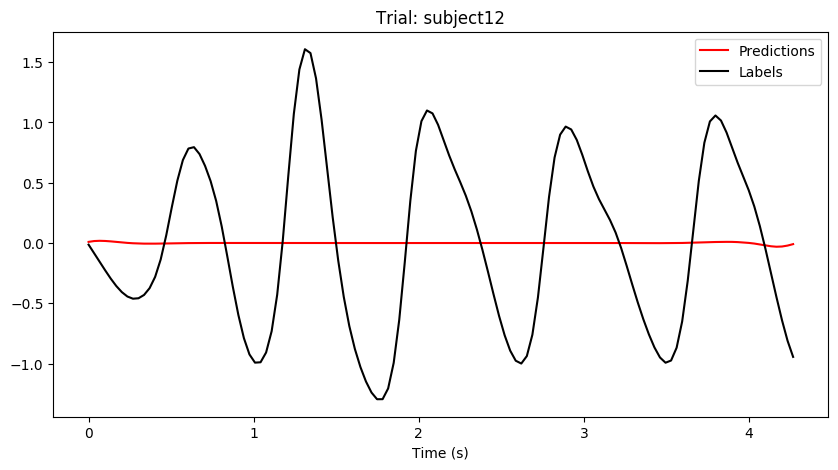

In [5]:
# 从多个试验块中重构标签和预测向量
prediction = np.array(_reform_data_from_dict(data['predictions'][trial_list[trial_idx]]))
label = np.array(_reform_data_from_dict(data['labels'][trial_list[trial_idx]]))

# 从pickle文件中读取元数据
fs = data['fs']  
label_type = data['label_type']  # PPG信号变换类型：'DiffNormalized'或'Standardized'
diff_flag = (label_type == 'DiffNormalized')  # 判断是否使用差分归一化

# 设置数据块大小
if chunk_size == -1:
    chunk_size = len(prediction)  # 如果chunk_size为-1，则使用整个信号长度
    chunk_num = 0

# 处理标签和预测信号
prediction = _process_signal(prediction, fs, diff_flag=diff_flag)  
label = _process_signal(label, fs, diff_flag=diff_flag) 

# 计算当前数据块的起始和结束位置
start = (chunk_num)*chunk_size
stop = (chunk_num+1)*chunk_size
samples = stop - start
x_time = np.linspace(0, samples/fs, num=samples)  

# 绘制图形
plt.figure(figsize=(10,5))  
plt.plot(x_time, prediction[start:stop], color='r') 
plt.plot(x_time, label[start:stop], color='black') 
plt.title('Trial: ' + trial_list[trial_idx])  
plt.legend(['Predictions', 'Labels']) 
plt.xlabel('Time (s)') 